<a href="https://colab.research.google.com/github/Mychail/Data_Science/blob/main/Rainfall_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle (1).json


In [ ]:
!kaggle competitions download -c playground-series-s5e3

playground-series-s5e3.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -qq playground-series-s5e3.zip

replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
!pip install catboost
!pip install lightgbm

## **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

### **Load Datasets**

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# verify shapes
print("Train Data Shape", train_data.shape)
print("Test Data Shape", test_data.shape)

Train Data Shape (2190, 13)
Test Data Shape (730, 12)


## **Exploratory Data Analysis EDA**

### **Checking Basic Statistics**

In [ ]:
# Display Sample data
print("\nTrain Data Head:")
display(train_data.head())

print("\nTest Data Head:")
display(test_data.head())


Train Data Head:


id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
0   0    1    1017.4     21.2         20.6     19.9      19.4      87.0   
1   1    2    1019.5     16.2         16.9     15.8      15.4      95.0   
2   2    3    1024.1     19.4         16.1     14.6       9.3      75.0   
3   3    4    1013.4     18.1         17.8     16.9      16.8      95.0   
4   4    5    1021.8     21.3         18.4     15.2       9.6      52.0   

   cloud  sunshine  winddirection  windspeed  rainfall  
0   88.0       1.1           60.0       17.2         1  
1   91.0       0.0           50.0       21.9         1  
2   47.0       8.3           70.0       18.1         1  
3   95.0       0.0           60.0       35.6         1  
4   45.0       3.6           40.0       24.8         0


Test Data Head:


id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
0  2190    1    1019.5     17.5         15.8     12.7      14.9      96.0   
1  2191    2    1016.5     17.5         16.5     15.8      15.1      97.0   
2  2192    3    1023.9     11.2         10.4      9.4       8.9      86.0   
3  2193    4    1022.9     20.6         17.3     15.2       9.5      75.0   
4  2194    5    1022.2     16.1         13.8      6.4       4.3      68.0   

   cloud  sunshine  winddirection  windspeed  
0   99.0       0.0           50.0       24.3  
1   99.0       0.0           50.0       35.3  
2   96.0       0.0           40.0       16.9  
3   45.0       7.1           20.0       50.6  
4   49.0       9.2           20.0       19.4

In [ ]:
# Display Sample data
print("\nTrain Data Head:")
display(train_data.tail())

print("\nTest Data Head:")
display(test_data.tail())


Train Data Head:


id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
2185  2185  361    1014.6     23.2         20.6     19.1      19.9      97.0   
2186  2186  362    1012.4     17.2         17.3     16.3      15.3      91.0   
2187  2187  363    1013.3     19.0         16.3     14.3      12.6      79.0   
2188  2188  364    1022.3     16.4         15.2     13.8      14.7      92.0   
2189  2189  365    1013.8     21.2         19.1     18.0      18.0      89.0   

      cloud  sunshine  winddirection  windspeed  rainfall  
2185   88.0       0.1           40.0       22.1         1  
2186   88.0       0.0           50.0       35.3         1  
2187   79.0       5.0           40.0       32.9         1  
2188   93.0       0.1           40.0       18.0         1  
2189   88.0       1.0           70.0       48.0         1


Test Data Head:


id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
725  2915  361    1020.8     18.2         17.6     16.1      13.7      96.0   
726  2916  362    1011.7     23.2         18.1     16.0      16.0      78.0   
727  2917  363    1022.7     21.0         18.5     17.0      15.5      92.0   
728  2918  364    1014.4     21.0         20.0     19.7      19.8      94.0   
729  2919  365    1020.9     22.2         18.8     17.0      13.3      79.0   

     cloud  sunshine  winddirection  windspeed  
725   95.0       0.0           20.0       34.3  
726   80.0       1.6           40.0       25.2  
727   96.0       0.0           50.0       21.9  
728   93.0       0.0           50.0       39.5  
729   89.0       0.2           60.0       50.6

In [ ]:
# look at the distribution of each day in the dataset
train_data['day'].value_counts()

day
91     7
144    7
267    7
140    7
111    7
      ..
157    5
286    5
38     5
336    5
365    5
Name: count, Length: 365, dtype: int64

In [ ]:
# Display information about the DataFrames
print("\nTrain Data Info:")
print(train_data.info())

print("\nTest Data Info:")
print(test_data.info())


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column         Non-Null Count 

In [ ]:
# Display null Counts
print("\nTrain Data Null Counts:")
print(train_data.isnull().sum().sum())

print("\nTest Data Null Counts:")
print(test_data.isnull().sum().sum())


Train Data Null Counts:
0

Test Data Null Counts:
1


In [ ]:
# display columns names of DataFrames
print("\nTrain Data Columns:")
print(train_data.columns)

print("\nTest Data Columns:")
print(test_data.columns)


Train Data Columns:
Index(['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall'],
      dtype='object')

Test Data Columns:
Index(['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed'],
      dtype='object')


In [ ]:
# display statistics of the dataframes
print("\nTrain Data Statistics:")
print(train_data.describe().T)

print("\nTest Data Statistics:")
print(test_data.describe().T)


Train Data Statistics:
                count         mean         std    min       25%      50%  \
id             2190.0  1094.500000  632.342866    0.0   547.250  1094.50   
day            2190.0   179.948402  105.203592    1.0    89.000   178.50   
pressure       2190.0  1013.602146    5.655366  999.0  1008.600  1013.00   
maxtemp        2190.0    26.365799    5.654330   10.4    21.300    27.80   
temparature    2190.0    23.953059    5.222410    7.4    19.300    25.50   
mintemp        2190.0    22.170091    5.059120    4.0    17.700    23.85   
dewpoint       2190.0    20.454566    5.288406   -0.3    16.800    22.15   
humidity       2190.0    82.036530    7.800654   39.0    77.000    82.00   
cloud          2190.0    75.721918   18.026498    2.0    69.000    83.00   
sunshine       2190.0     3.744429    3.626327    0.0     0.400     2.40   
winddirection  2190.0   104.863151   80.002416   10.0    40.000    70.00   
windspeed      2190.0    21.804703    9.898659    4.4    14.125 

### **Dataset Overview**

There are 2090 records in the training data and 730 records in the Test data.
 * There are no null values in the training data whereas the windirection column in the test data is missing a value.




---

# **Dataset Information**

## **Train Dataset Columns**
- **ID**: A unique identifier for each record.
- **Day**: The day of the year (ranging from 1 to 365).
- **Pressure**: Atmospheric pressure in hPa, ranging from **999 to 1034.6** hPa.
- **Max Temperature** (`maxtemp`): The highest recorded temperature of the day in °C, ranging from **10.4 to 36.0** °C.
- **Temperature** (`temparature`): The average temperature of the day in °C, ranging from **7.4 to 31.5** °C.
- **Min Temperature** (`mintemp`): The lowest recorded temperature of the day in °C, ranging from **4.0 to 29.8** °C.
- **Dew Point**: The temperature at which air becomes saturated with moisture, measured in °C, ranging from **-0.3 to 26.7** °C.
- **Humidity**: The relative humidity percentage of the atmosphere, ranging from **39% to 98%**.
- **Cloud Cover** (`cloud`): The percentage of cloud cover, ranging from **2% to 100%**.
- **Sunshine Hours** (`sunshine`): The total duration of sunshine during the day in hours, ranging from **0.0 to 12.1** hours.
- **Wind Direction** (`winddirection`): The recorded direction of wind movement, measured in degrees (0°-360°), ranging from **10° to 300°**.
- **Wind Speed** (`windspeed`): The wind speed in km/h, ranging from **4.4 to 59.5** km/h.
- **Rainfall** (`rainfall`): Binary indicator of rainfall occurrence (**0 = No Rain, 1 = Rain**).

---

## **Test Dataset Columns**
- **ID**: A unique identifier for each test record.
- **Day**: The day of the year (ranging from 1 to 365).
- **Pressure**: Atmospheric pressure in hPa, ranging from **1000 to 1032.2** hPa.
- **Max Temperature** (`maxtemp`): The highest recorded temperature of the day in °C, ranging from **7.4 to 35.8** °C.
- **Temperature** (`temparature`): The average temperature of the day in °C, ranging from **5.9 to 31.8** °C.
- **Min Temperature** (`mintemp`): The lowest recorded temperature of the day in °C, ranging from **4.2 to 29.1** °C.
- **Dew Point**: The temperature at which air becomes saturated with moisture, measured in °C, ranging from **0.0 to 26.7** °C.
- **Humidity**: The relative humidity percentage of the atmosphere, ranging from **39% to 98%**.
- **Cloud Cover** (`cloud`): The percentage of cloud cover, ranging from **0% to 100%**.
- **Sunshine Hours** (`sunshine`): The total duration of sunshine during the day in hours, ranging from **0.0 to 11.8** hours.
- **Wind Direction** (`winddirection`): The recorded direction of wind movement, measured in degrees (0°-360°), ranging from **10° to 300°**.
- **Wind Speed** (`windspeed`): The wind speed in km/h, ranging from **4.5 to 59.5** km/h.

---

### **Key Differences Between Train and Test Datasets**
- The **test dataset** follows the same structure as the train dataset but does not include the `rainfall` column.
- The test dataset has slightly different **ranges** for some features, such as `pressure`, `temperature`, `cloud cover`, and `sunshine`.



In [ ]:
# fill the missing data
test_data['winddirection'].fillna(test_data['winddirection'].mean(), inplace=True)

In [ ]:
numerical_features = list(set(test_data.select_dtypes(include=['int64', 'float64']).columns) - {"id", "day"})
numerical_features

target_feature = 'rainfall'

### **Distribution Visualization**

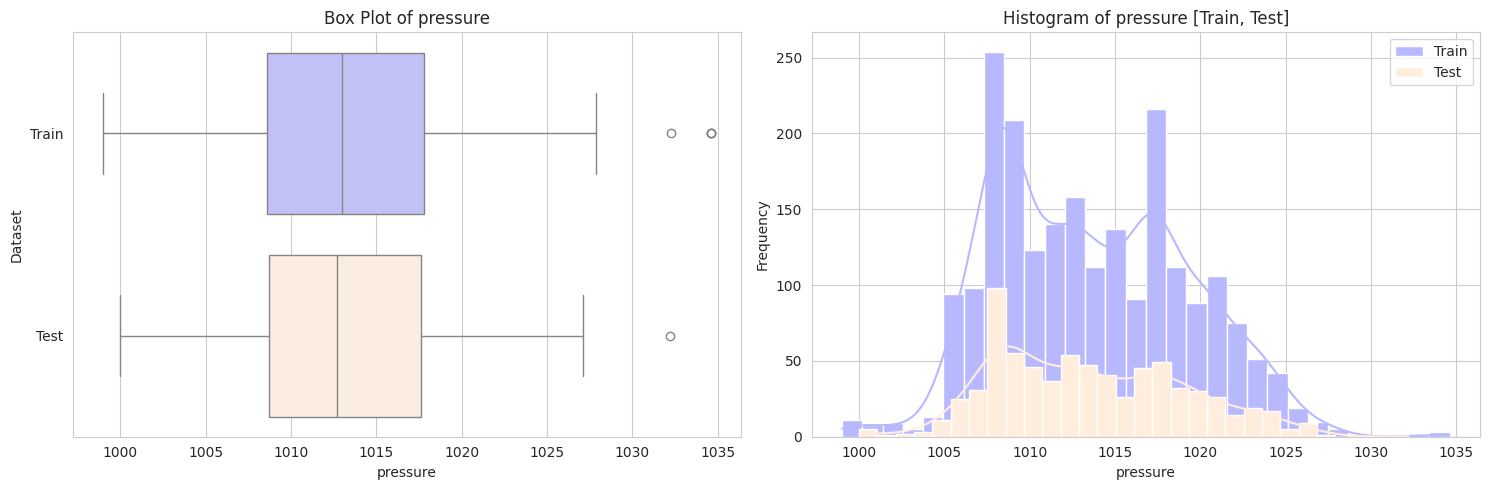

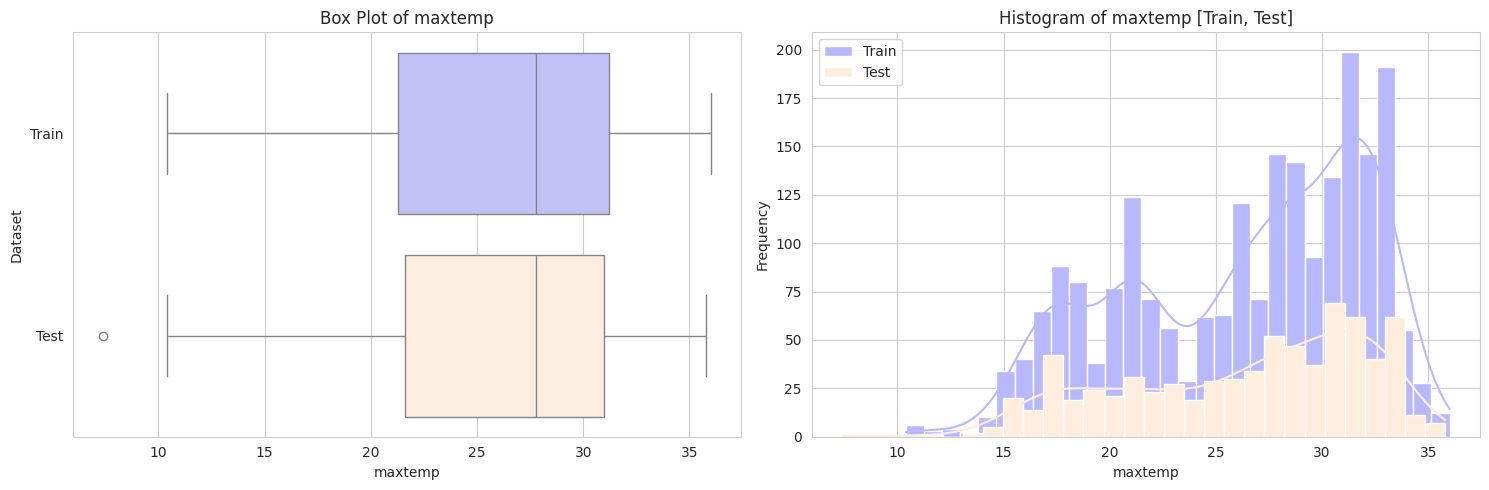

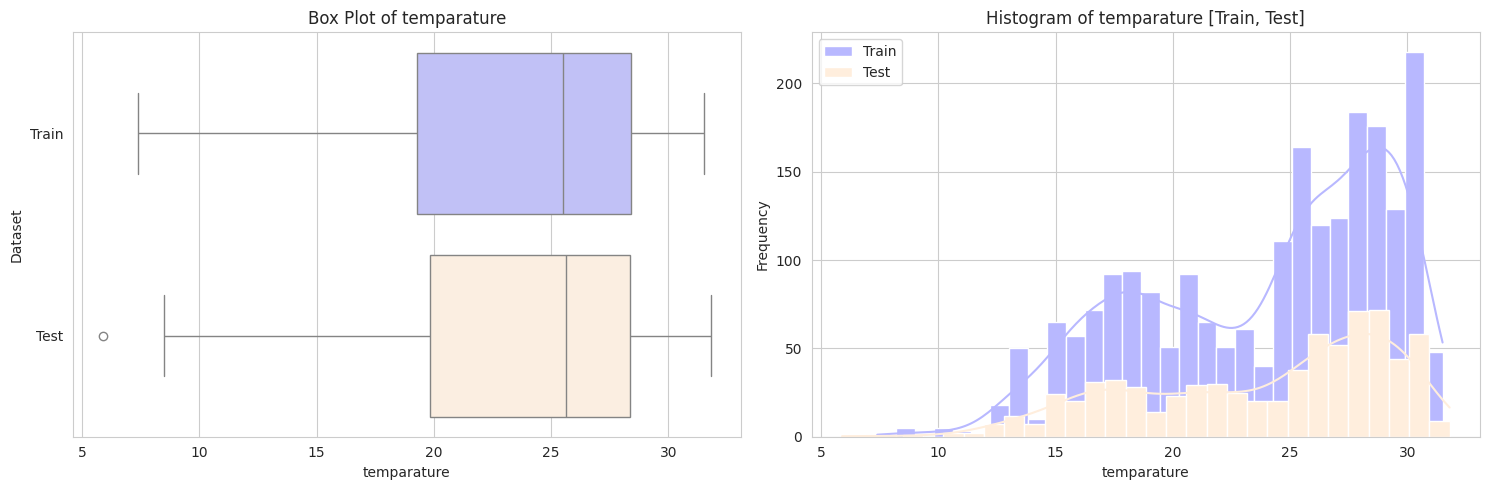

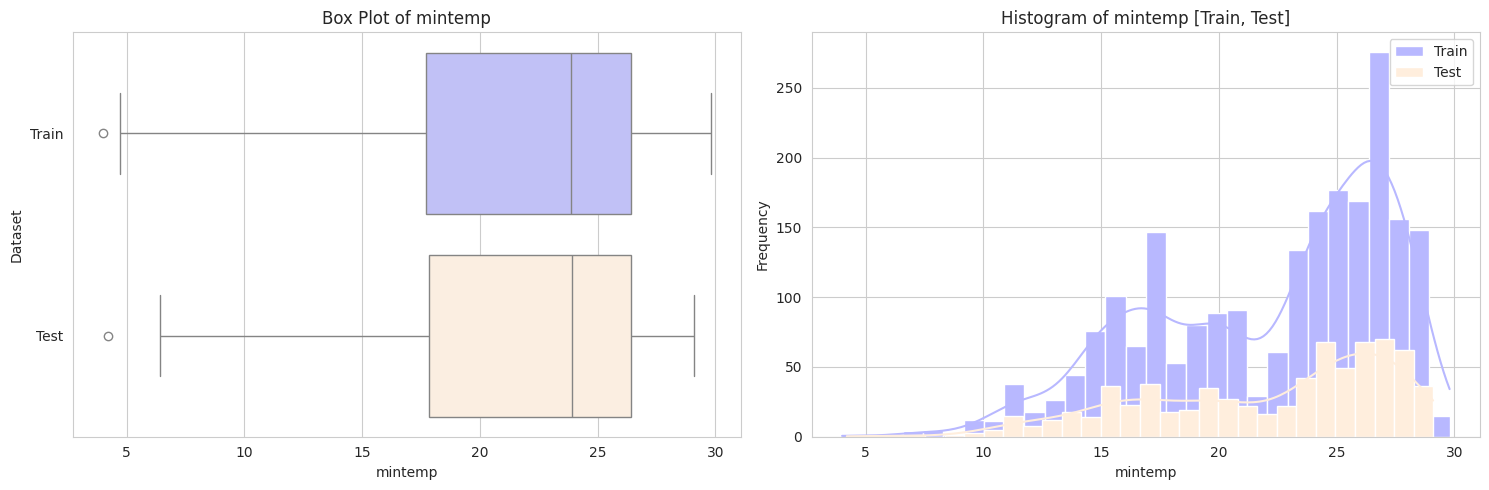

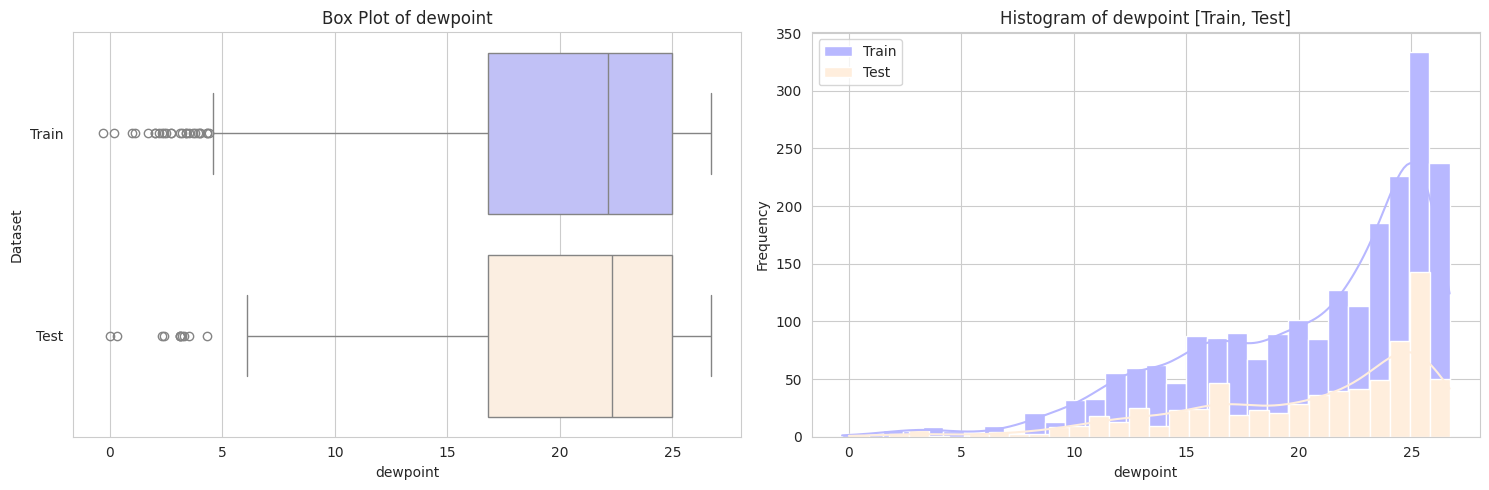

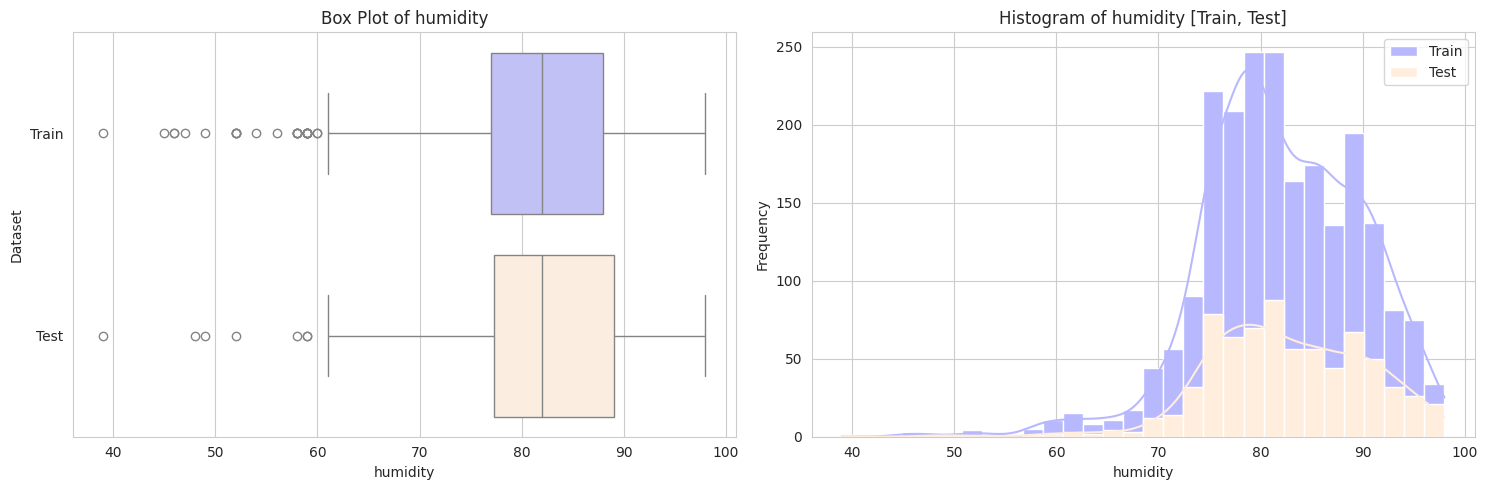

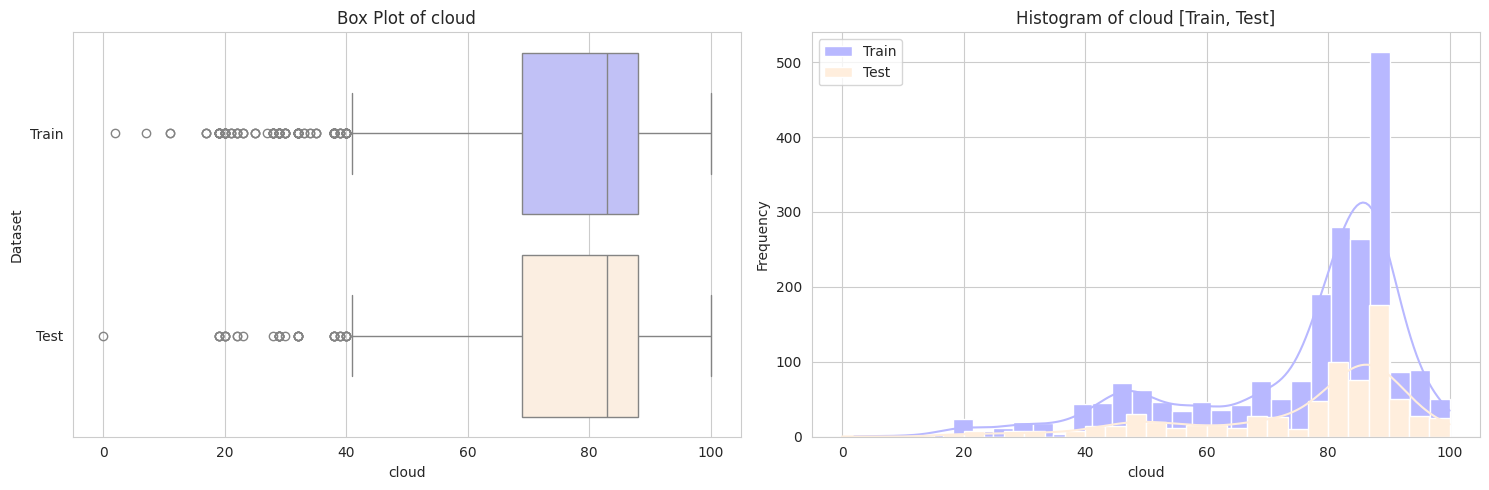

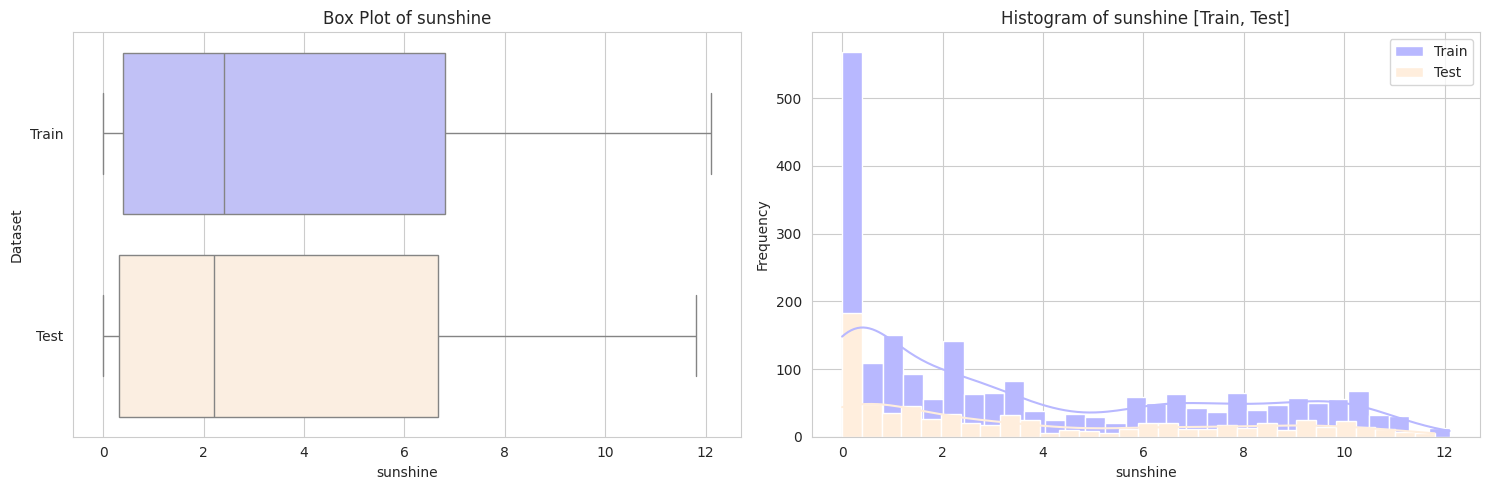

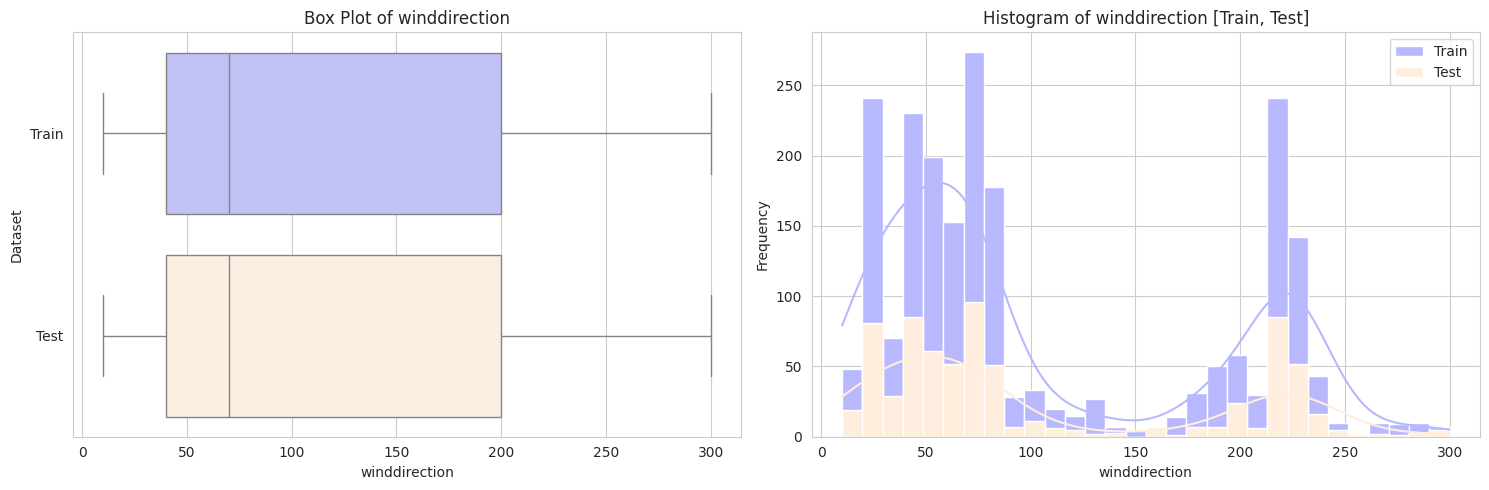

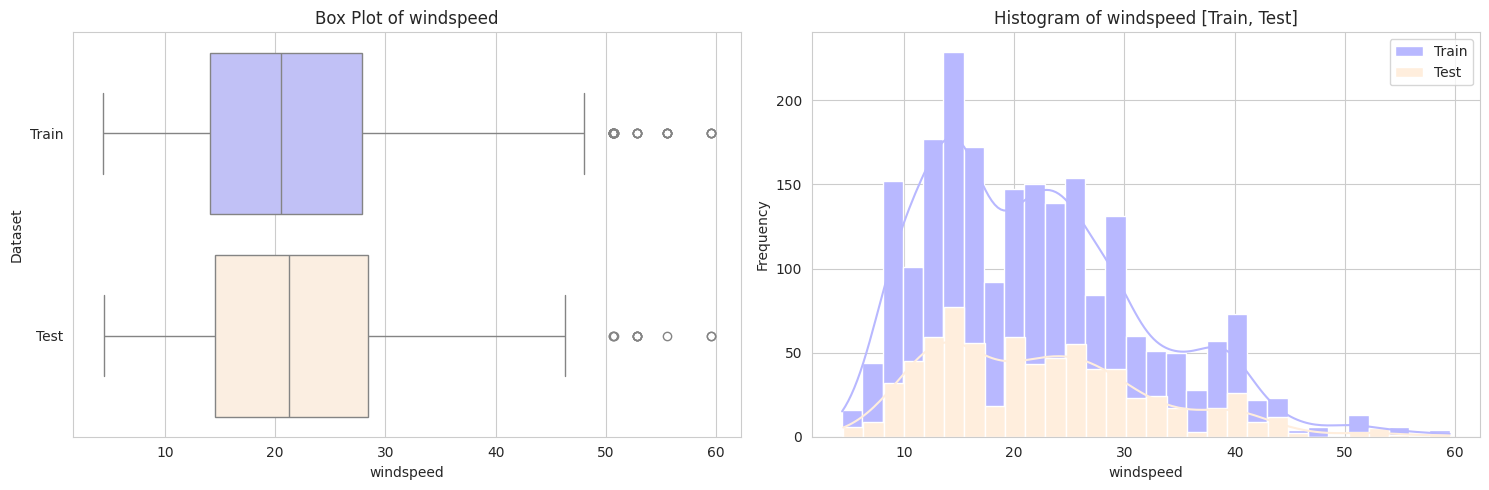

In [ ]:
# Analysis of all Numerical features

# define a custom color palette
custom_palette = ['#B8B8FF', '#FFEEDD','#944BBB', '#60E1E0' ]

# create a figure with subplots
# Define numerical features
variables = [col for col in train_data.columns if col not in ['id', 'day', 'rainfall']]

# function to create and display plots for a single numerical variable
def plot_variable(variable):
  sns.set_style('whitegrid')

  # merge data for visualization without changing original dataframes
  train_data_copy = train_data.copy()
  test_data_copy = test_data.copy()
  train_data_copy['Dataset'] = 'Train'
  test_data_copy['Dataset'] = 'Test'
  combined_data = pd.concat([train_data_copy, test_data_copy], axis=0)

  # create subplots
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

  # Box plot
  sns.boxplot(data=combined_data, x=variable, y = "Dataset", palette= custom_palette ,ax=axes[0])
  axes[0].set_xlabel(variable)
  axes[0].set_title(f'Box Plot of {variable}')

  # Histogram
  sns.histplot(data=train_data, x=variable, kde=True, ax=axes[1], bins= 30, label = 'Train', color= custom_palette[0], alpha=1)
  sns.histplot(data=test_data, x=variable, kde=True, ax=axes[1], bins= 30, label = 'Test', color= custom_palette[1], alpha = 1)
  axes[1].set_xlabel(variable)
  axes[1].set_ylabel('Frequency')
  axes[1].set_title(f'Histogram of {variable} [Train, Test]')
  axes[1].legend()

  # Adjust spacing and show plots
  plt.tight_layout()
  plt.show()



for variable in variables:
  plot_variable(variable)

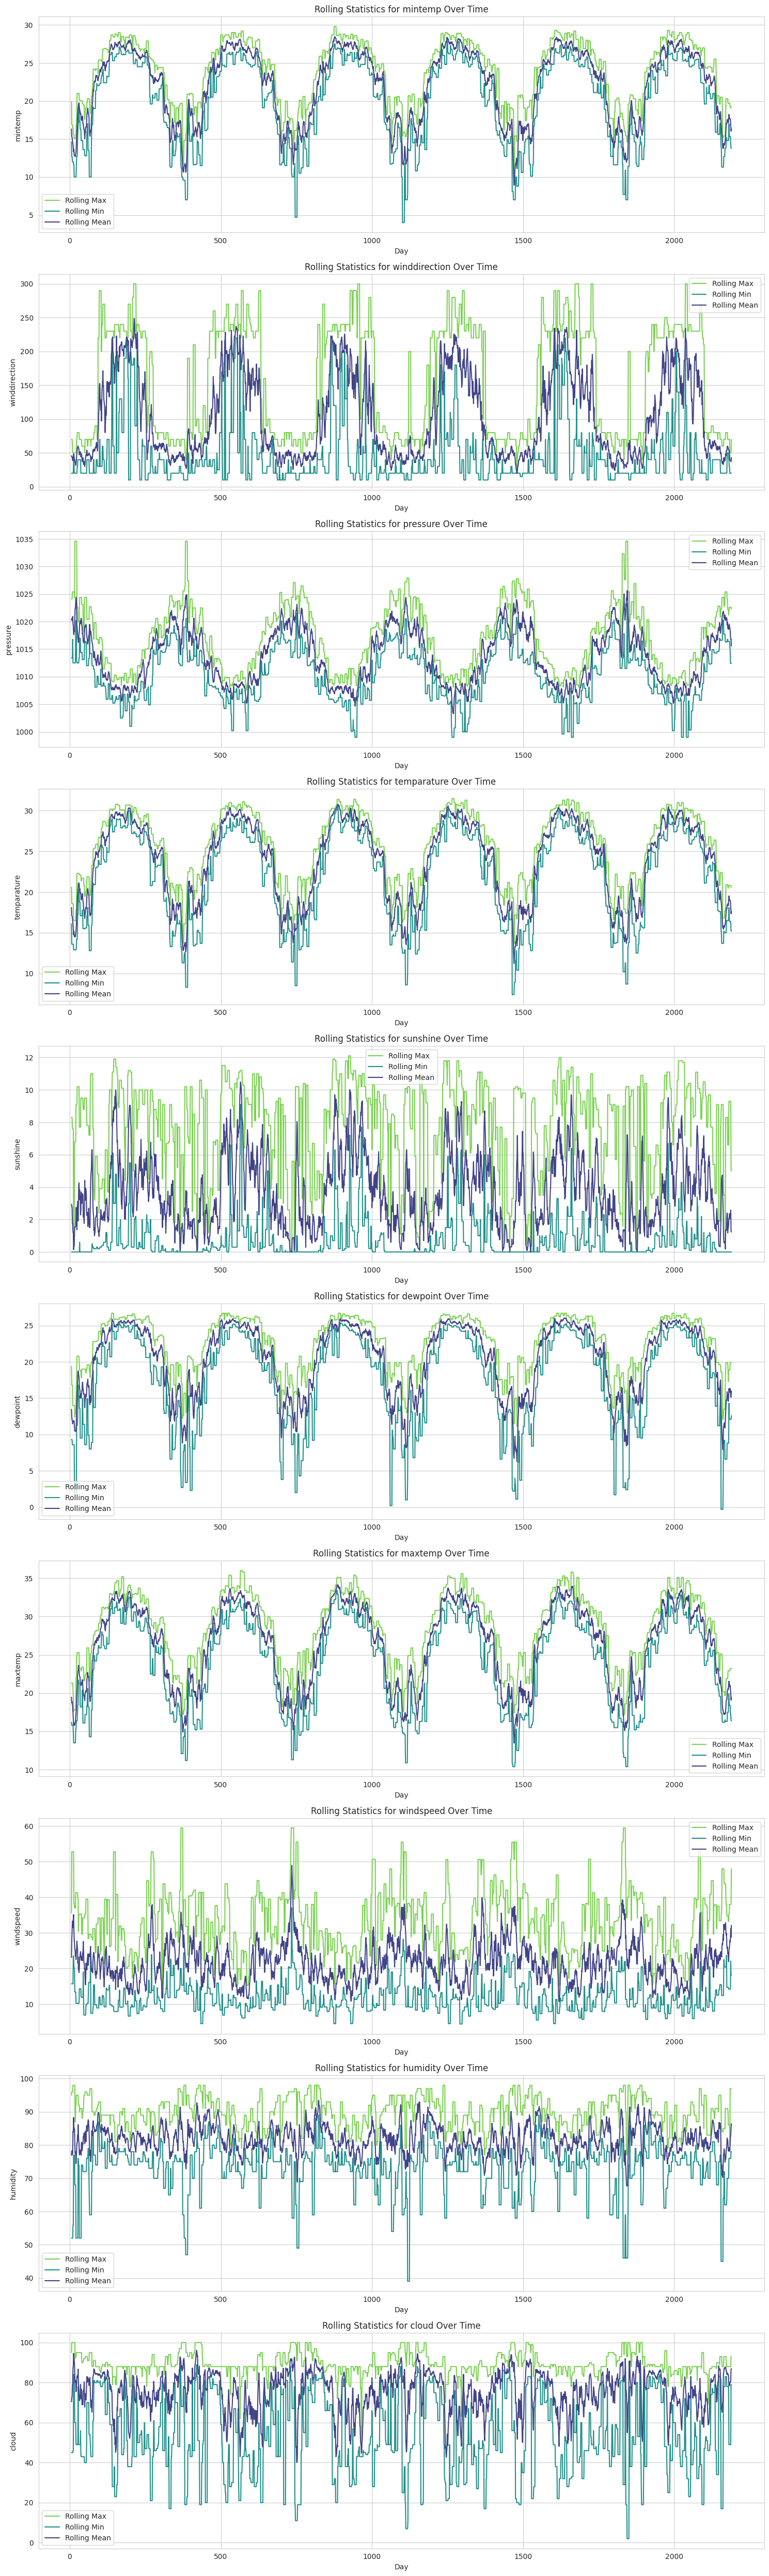

In [ ]:
# Define colormap
cmap = plt.get_cmap('viridis')
colors = [cmap(0.8), cmap(0.5), cmap(0.2)]

# create subplots
fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(15, 5 * len(numerical_features)))

# iterate over numerical features
for i, feature in enumerate(numerical_features):
  rolling_max = train_data[feature].rolling(window=7).max()
  rolling_min = train_data[feature].rolling(window=7).min()
  rolling_mean = train_data[feature].rolling(window=7).mean()

  axes[i].plot(rolling_max, label='Rolling Max', color=colors[0])
  axes[i].plot(rolling_min, label='Rolling Min', color=colors[1])
  axes[i].plot(rolling_mean, label='Rolling Mean', color=colors[2])

  axes[i].set_title(f'Rolling Statistics for {feature} Over Time')
  axes[i].set_xlabel('Day')
  axes[i].set_ylabel(feature)
  axes[i].grid(True)
  axes[i].legend()

plt.tight_layout()
plt.show()

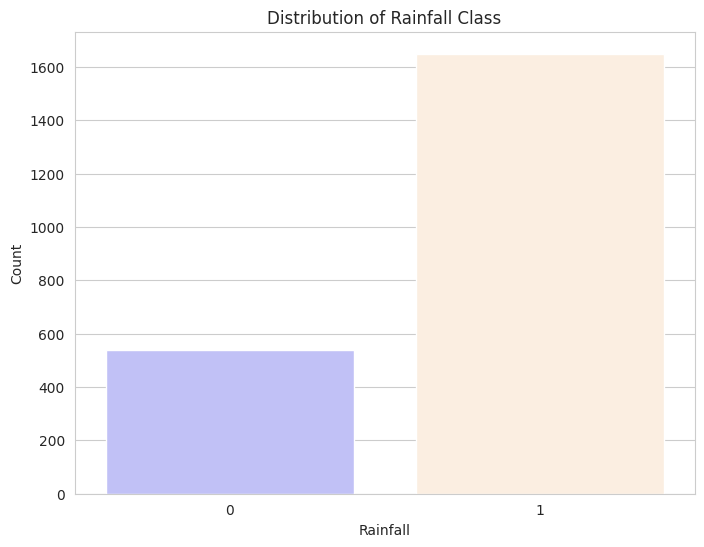

In [ ]:
# distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x=target_feature, data=train_data, palette=custom_palette)
plt.title('Distribution of Rainfall Class')
plt.xlabel('Rainfall')
plt.ylabel('Count')
plt.show()

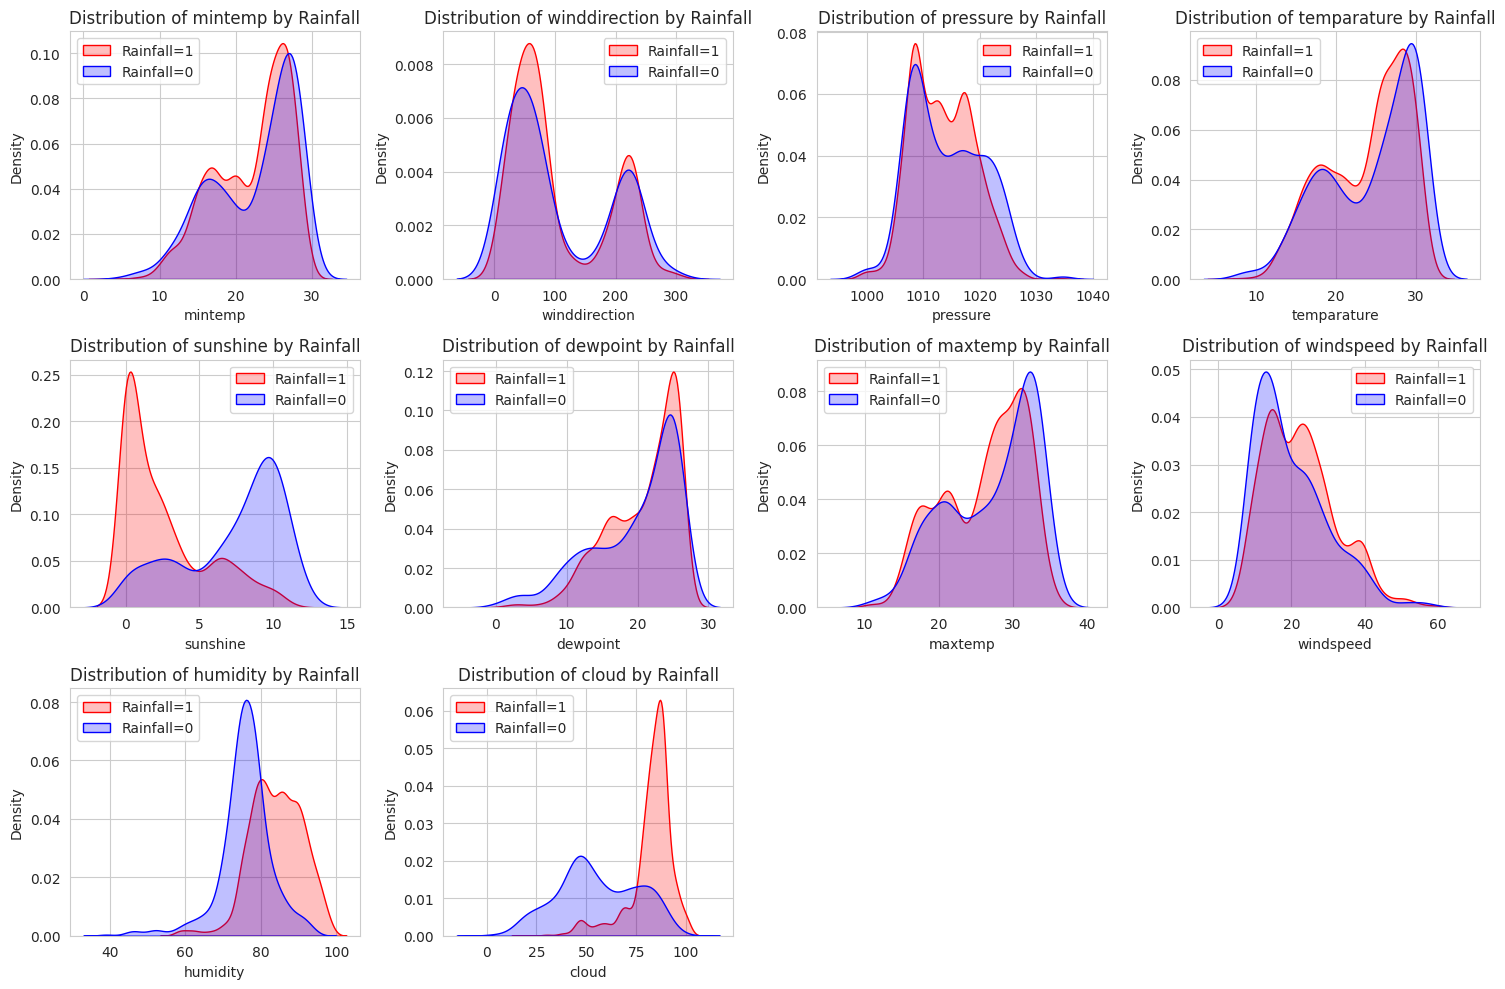

In [ ]:
# KDE plot for feature-Target Relationship
plt.figure(figsize = [15, 10])

for i, col in enumerate( numerical_features, 1):
  plt.subplot(3, 4, i)
  sns.kdeplot(train_data[col][train_data["rainfall"]==1], color='red', label='Rainfall=1', shade=True)
  sns.kdeplot(train_data[col][train_data["rainfall"]==0], color='blue', label='Rainfall=0', shade=True)
  plt.title(f"Distribution of {col} by Rainfall")
  plt.legend()

plt.tight_layout()
plt.show()


### **Key Takeaways from the KDE Plot Analysis**

#### **Factors That Increase the Likelihood of Rainfall (`rainfall = 1`)**
1. **High Humidity** – Rainfall is strongly associated with higher humidity levels.  
2. **Low Pressure** – Rain tends to occur under lower atmospheric pressure.  
3. **High Dew Point** – A higher dew point correlates with increased moisture in the air, making rain more likely.  
4. **Low Sunshine** – Rainfall events are more frequent when there is less sunlight.  
5. **High Cloud Cover** – More cloud cover significantly increases the probability of rainfall.  

#### **Weaker Predictors of Rainfall**
- **Wind Speed & Wind Direction** – While there are variations, they are not as strong indicators compared to the factors above.  
- **Temperature & Maximum Temperature** – Rain tends to occur at slightly lower temperatures, but the difference is not highly significant.  

<Figure size 1500x1500 with 0 Axes>

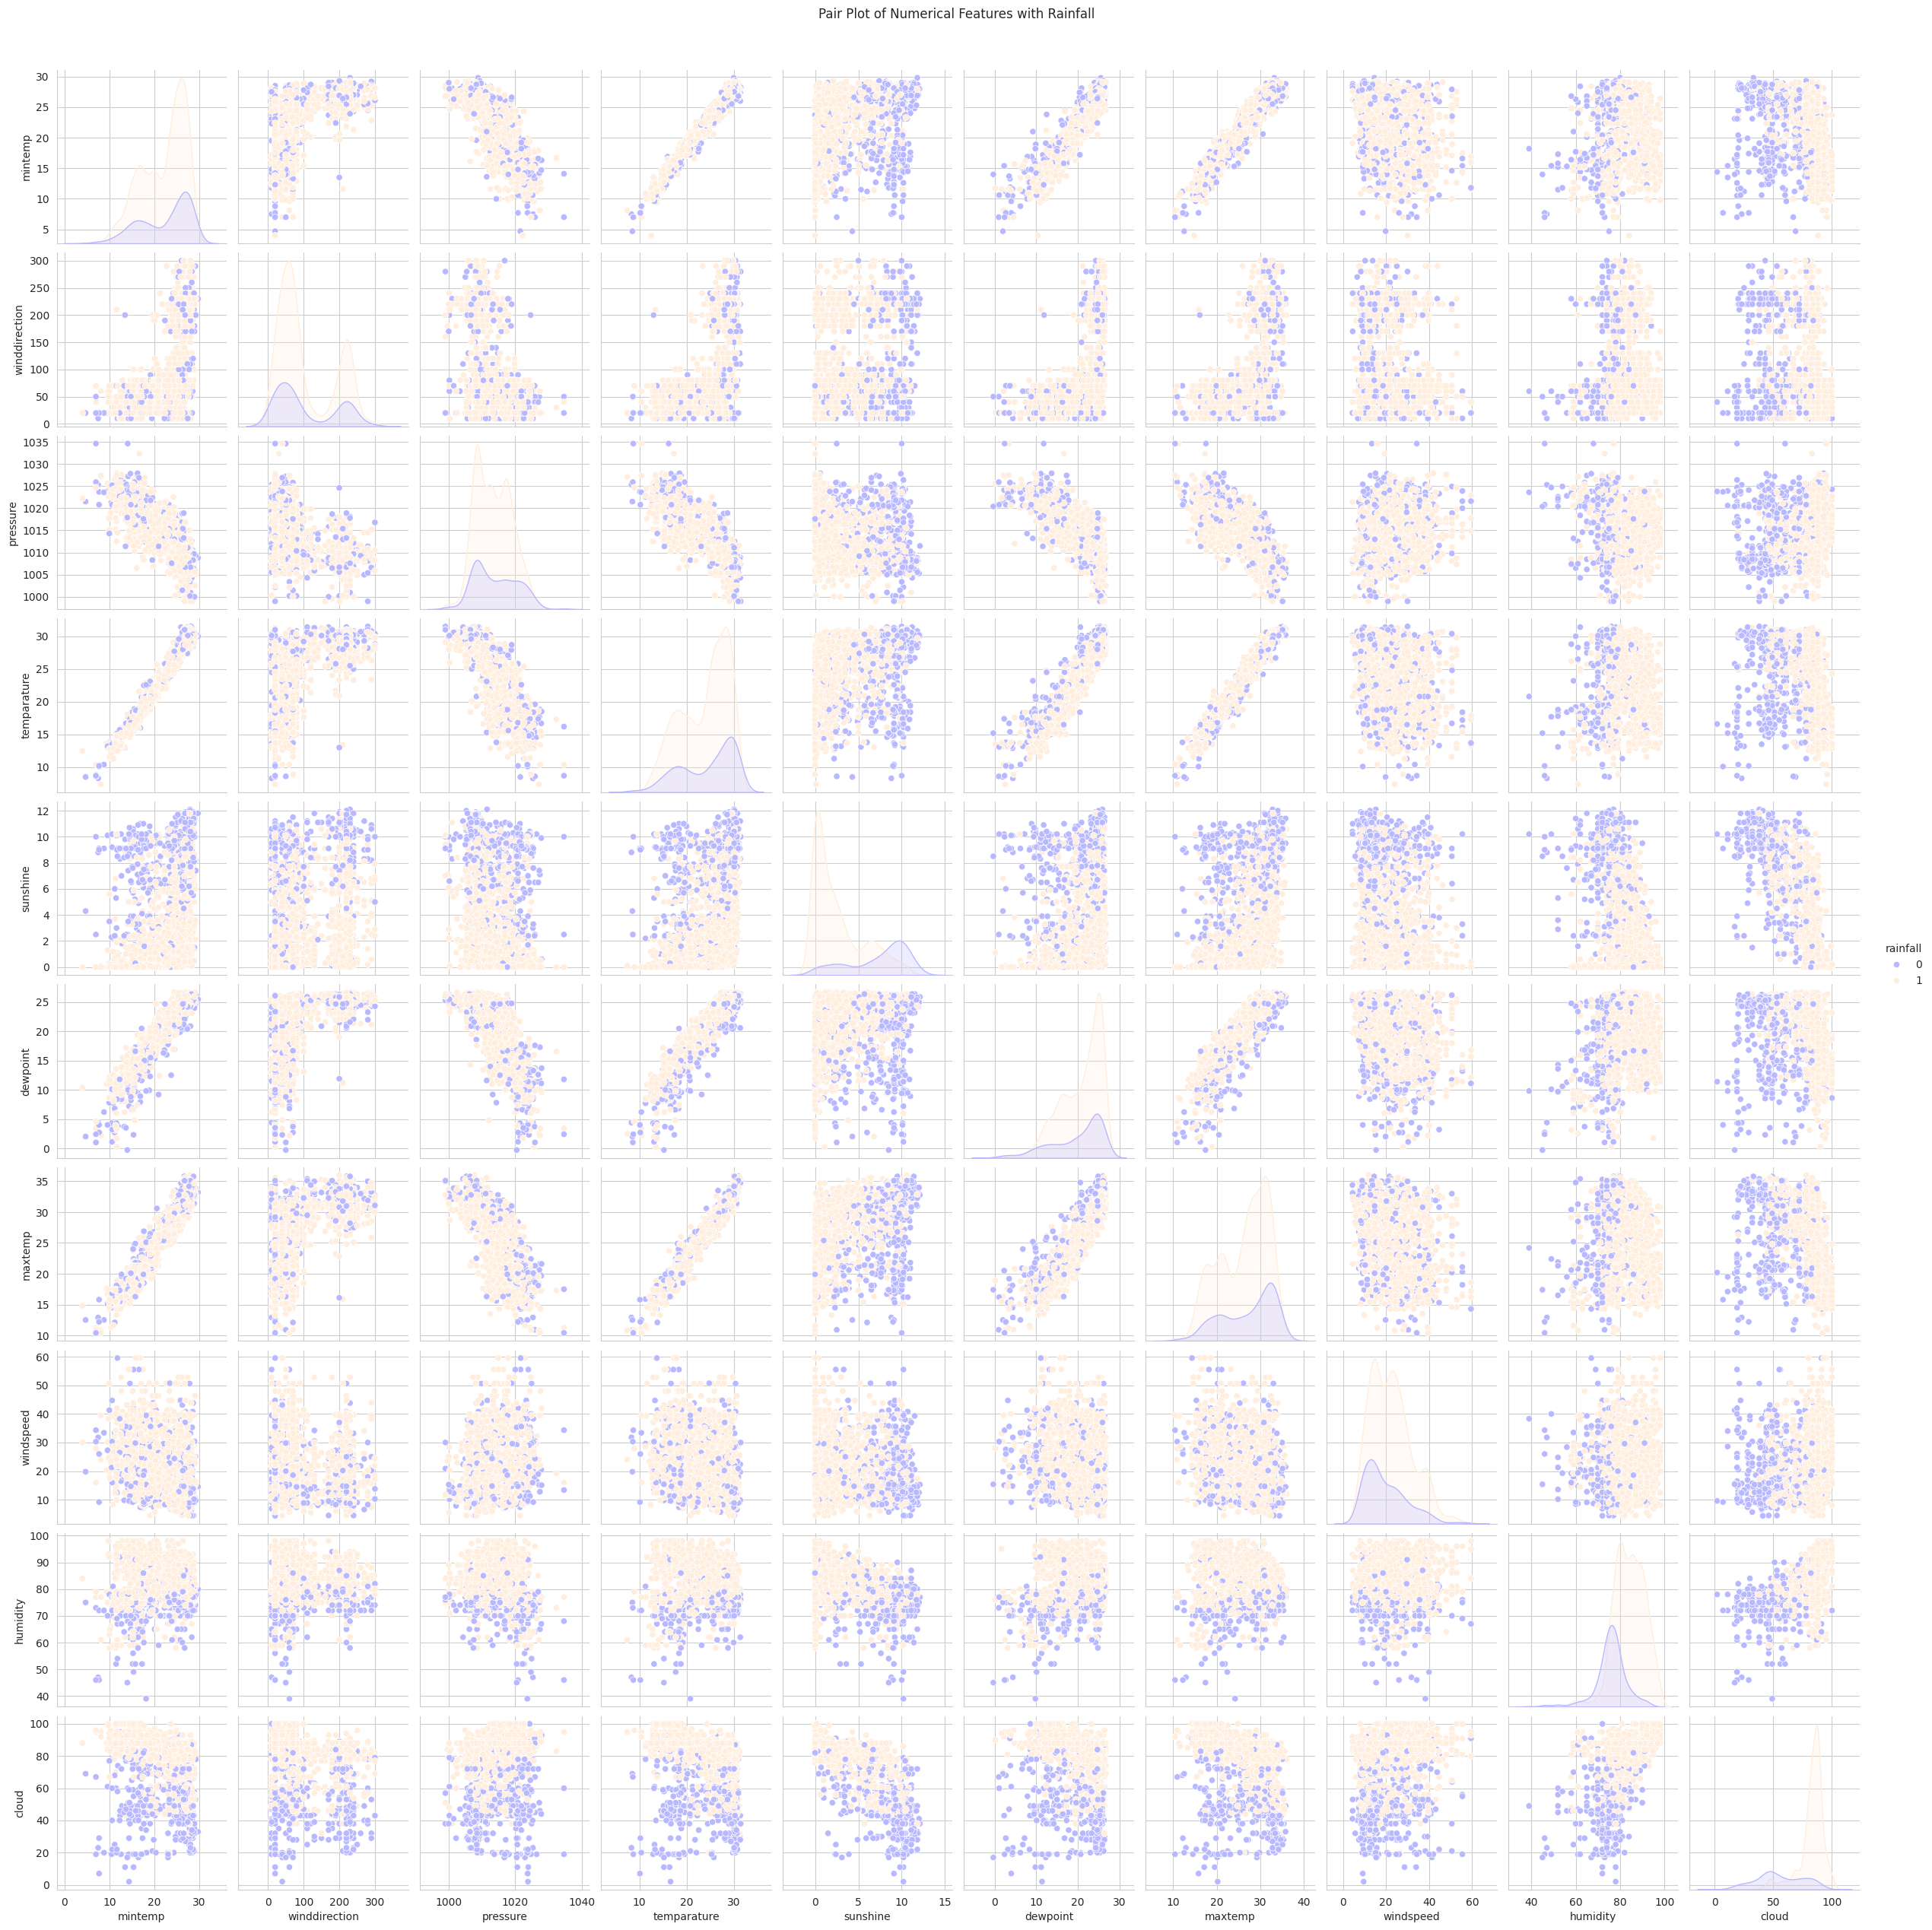

In [ ]:
plt.figure(figsize=(15, 15))
sns.pairplot(train_data[numerical_features + [target_feature]], hue=target_feature, palette=custom_palette)
plt.suptitle('Pair Plot of Numerical Features with Rainfall', y=1.02)
plt.show()

### **Key Takeaways from the Pair Plot Analysis**  

- **Humidity and Rainfall**: Higher humidity is strongly associated with rainfall.  
- **Pressure and Rainfall**: Rainfall tends to occur under lower atmospheric pressure conditions.  
- **Sunshine and Rainfall**: Rainfall is more likely when sunshine levels are lower.  
- **Cloud Cover and Rainfall**: Increased cloud cover is a strong indicator of rainfall.  
- **Temperature and Rainfall**: Rainfall is slightly more common at lower temperatures.  
- **Feature Relationships**:  
  - Temperature and max temperature show a strong linear correlation.  
  - Humidity and pressure exhibit an inverse relationship.  
  - Sunshine and cloud cover are inversely related, reinforcing their importance in predicting rainfall.  
- **Rainfall Clustering**: Data points for rainfall occurrences (`rainfall=1`) tend to form distinct clusters in specific feature interactions, suggesting their predictive potential.

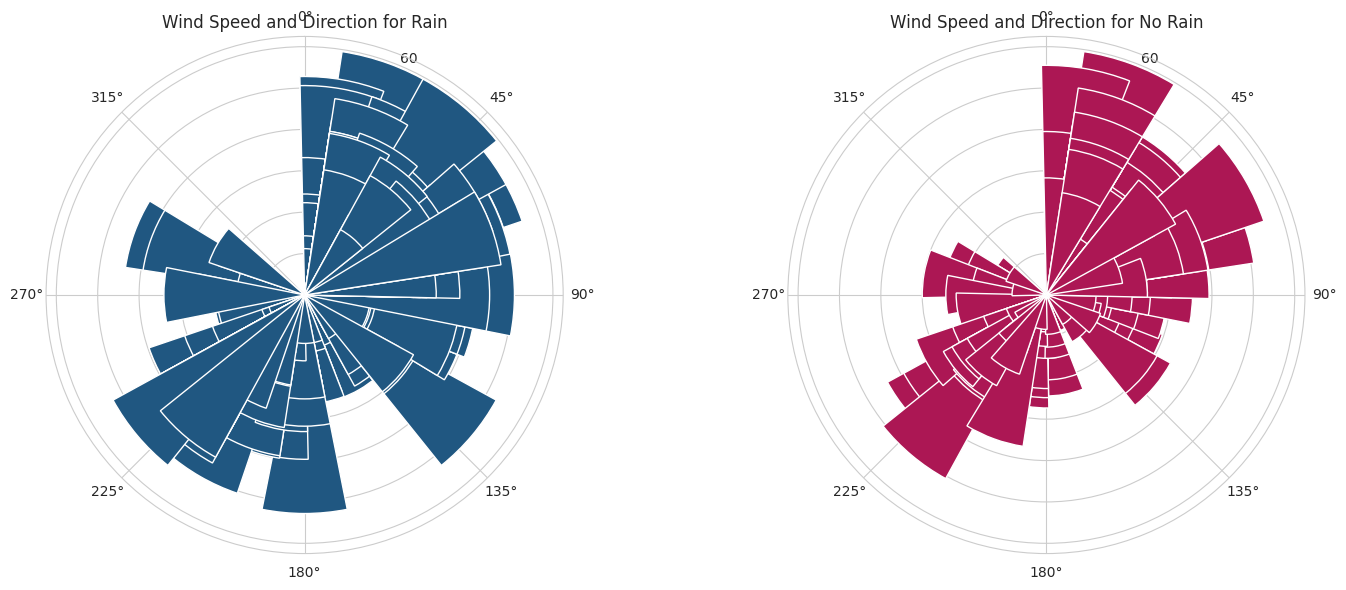

In [ ]:
# Filter data based on rainfall
rain_data = train_data[train_data['rainfall'] == 1]
no_rain_data = train_data[train_data['rainfall'] == 0]

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2,subplot_kw={'projection': 'polar'}, figsize=(15, 6))

# Wind rise plot for rain
ax1 = axes[0]
ax1.set_theta_direction(-1)
ax1.set_theta_offset(np.pi / 2)
bars1 = ax1.bar(np.radians(rain_data['winddirection']), rain_data['windspeed'], width=np.pi/8, color='#205781', bottom = 0.0)
ax1.set_title('Wind Speed and Direction for Rain')

# Secon Wind rise plot for No Rain
ax2 = axes[1]
ax2.set_theta_direction(-1)
ax2.set_theta_offset(np.pi / 2)
bar2s = ax2.bar(np.radians(no_rain_data['winddirection']), no_rain_data['windspeed'], width=np.pi/8, color='#AC1754', bottom = 0.0)
ax2.set_title('Wind Speed and Direction for No Rain')

plt.tight_layout()
plt.show()

### **Key Takeaways from the Wind Speed and Direction Analysis**  

- **Wind direction during rainfall is more concentrated**, indicating that rain is often associated with winds coming from specific directions.  
- **Wind speed is generally higher during rainfall**, suggesting that stronger winds may contribute to or result from rainfall conditions.  
- **Non-rainy conditions exhibit more dispersed wind directions**, implying less structured wind patterns compared to rainy periods.  
- **Wind characteristics can serve as predictive features** for rainfall forecasting, with specific wind speeds and directions correlating with rainfall occurrence.

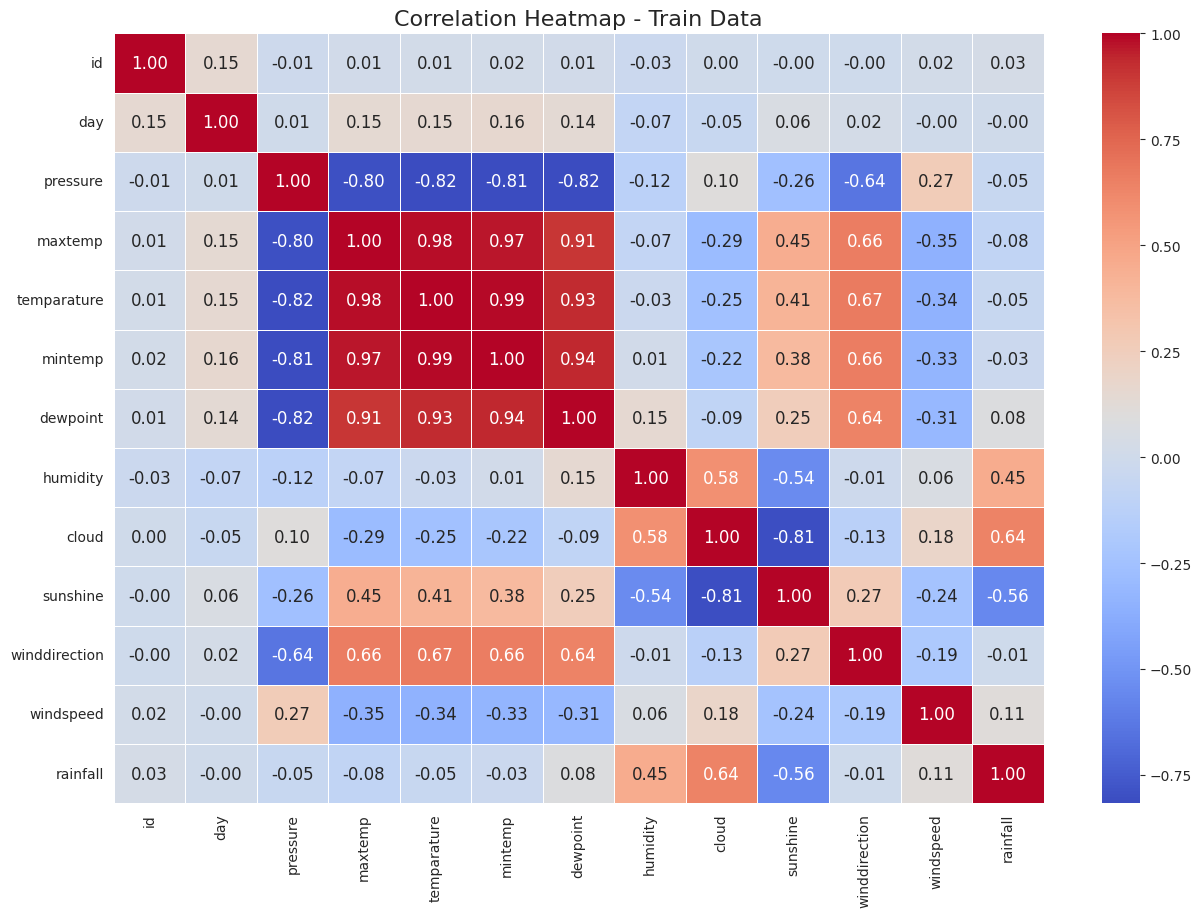

In [ ]:
# Correlation Heatmap
def corr_plot_heatmap(df, title, annot_size = 12):
    plt.figure(figsize= [15, 10])
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': annot_size}, linewidths= 0.5)
    plt.title(f'Correlation Heatmap - {title}', fontsize = 16)
    plt.show()

corr_plot_heatmap(train_data, title='Train Data')

### **Key Takeaways from the Correlation Heatmap**  

- **Strong Positive Correlations:**  
  - **Temperature, max temperature, and min temperature** are highly correlated (≥ 0.97), indicating redundancy in these features.  
  - **Cloud cover and humidity (0.64)** show a notable positive correlation with rainfall, suggesting they are strong indicators of precipitation.  

- **Strong Negative Correlations:**  
  - **Pressure is inversely correlated with temperature (-0.82 to -0.80), dew point (-0.82), and cloud cover (-0.64).** This aligns with meteorological principles where lower pressure often leads to unstable atmospheric conditions and rainfall.  
  - **Sunshine and cloud cover (-0.81)** exhibit a strong inverse relationship, reinforcing their complementary roles in weather patterns.  
  - **Sunshine is negatively correlated with rainfall (-0.56),** indicating that less sunshine is associated with higher rainfall probability.  

- **Rainfall-Specific Insights:**  
  - **Rainfall has the highest positive correlation with cloud cover (0.64) and humidity (0.45),** suggesting these are key predictors for precipitation.  
  - **Rainfall is negatively correlated with sunshine (-0.56),** highlighting that reduced solar exposure is linked to rain events.  
  - **Wind speed has a weak positive correlation with rainfall (0.11),** implying a minor impact on precipitation compared to other features.  

- **Implications for Predictive Modeling:**  
  - **Cloud cover, humidity, and sunshine** should be prioritized as predictive features for rainfall forecasting.  
  - **Pressure and temperature relationships** should be considered carefully, as they may introduce collinearity into models.  
  - **Dimensionality reduction techniques (e.g., PCA or feature selection)** can help remove redundant features, especially among temperature variables.

## **Feature Engineering**

In [ ]:
def preprocess_data(df):
    # Extract month and day from the 'day' column
    df['month'] = df['day'].apply(lambda x: (x - 1) // 30 + 1)
    #df['season'] = df['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else ('Spring' if x in [3, 4, 5] else ('Summer' if x in [6, 7, 8] else 'Fall')))
    df['day_of_week'] = df['day'].apply(lambda x: (x - 1) % 7 + 1)

    df['humidity_temp_ratio'] = df['humidity'] / (df['temparature'] + 1)
    df['pressure_cloud_interaction'] = df['pressure'] * df['cloud']
    df['sunshine_windspeed_interaction'] = df['sunshine'] * df['windspeed']
    df['cloud_sunshine_ratio'] = df['cloud'] / (df['sunshine'] + 1)
    df['humidity_pressure_ratio'] = df['humidity'] / (df['pressure'] + 1)
    df['wind_x'] = np.cos(np.radians(df['winddirection']))
    df['wind_y'] = np.sin(np.radians(df['winddirection']))

    # Seasonal deviation from mean values

    df['dew_humidity'] = df['dewpoint'] * df['humidity']
    df['cloud_windspeed'] = df['cloud'] * df['windspeed']
    df['temp_to_sunshine'] = df['sunshine'] / df['temparature']
    df['cloud_humidity/pressure'] = df['cloud'] * df['humidity'] / df['pressure']

    df = df.drop(columns = ['maxtemp', 'winddirection', 'humidity','temparature', 'pressure', 'day'])






    return df


# Apply to train and test datasets
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)


In [ ]:
display(train_data.head().T)

0             1             2  \
id                                  0.000000      1.000000      2.000000   
mintemp                            19.900000     15.800000     14.600000   
dewpoint                           19.400000     15.400000      9.300000   
cloud                              88.000000     91.000000     47.000000   
sunshine                            1.100000      0.000000      8.300000   
windspeed                          17.200000     21.900000     18.100000   
rainfall                            1.000000      1.000000      1.000000   
month                               1.000000      1.000000      1.000000   
day_of_week                         1.000000      2.000000      3.000000   
humidity_temp_ratio                 4.027778      5.307263      4.385965   
pressure_cloud_interaction      89531.200000  92774.500000  48132.700000   
sunshine_windspeed_interaction     18.920000      0.000000    150.230000   
cloud_sunshine_ratio               41.904762     91.000000      5.053763   
humidity_pressure_ratio             0.085428      0.093092      0.073164   
wind_x                              0.500000      0.642788      0.342020   
wind_y                              0.866025      0.766044      0.939693   
dew_humidity                     1687.800000   1463.000000    697.500000   
cloud_windspeed                  1513.600000   1992.900000    850.700000   
temp_to_sunshine                    0.053398      0.000000      0.515528   
cloud_humidity/pressure             7.525064      8.479647      3.442047   

                                           3             4  
id                                  3.000000      4.000000  
mintemp                            16.900000     15.200000  
dewpoint                           16.800000      9.600000  
cloud                              95.000000     45.000000  
sunshine                            0.000000      3.600000  
windspeed                          35.600000     24.800000  
rainfall                            1.000000      0.000000  
month                               1.000000      1.000000  
day_of_week                         4.000000      5.000000  
humidity_temp_ratio                 5.053191      2.680412  
pressure_cloud_interaction      96273.000000  45981.000000  
sunshine_windspeed_interaction      0.000000     89.280000  
cloud_sunshine_ratio               95.000000      9.782609  
humidity_pressure_ratio             0.093651      0.050841  
wind_x                              0.500000      0.766044  
wind_y                              0.866025      0.642788  
dew_humidity                     1596.000000    499.200000  
cloud_windspeed                  3382.000000   1116.000000  
temp_to_sunshine                    0.000000      0.195652  
cloud_humidity/pressure             8.905664      2.290076

In [ ]:
train_data.select_dtypes(exclude='object')

id  mintemp  dewpoint  cloud  sunshine  windspeed  rainfall  month  \
0        0     19.9      19.4   88.0       1.1       17.2         1      1   
1        1     15.8      15.4   91.0       0.0       21.9         1      1   
2        2     14.6       9.3   47.0       8.3       18.1         1      1   
3        3     16.9      16.8   95.0       0.0       35.6         1      1   
4        4     15.2       9.6   45.0       3.6       24.8         0      1   
...    ...      ...       ...    ...       ...        ...       ...    ...   
2185  2185     19.1      19.9   88.0       0.1       22.1         1     13   
2186  2186     16.3      15.3   88.0       0.0       35.3         1     13   
2187  2187     14.3      12.6   79.0       5.0       32.9         1     13   
2188  2188     13.8      14.7   93.0       0.1       18.0         1     13   
2189  2189     18.0      18.0   88.0       1.0       48.0         1     13   

      day_of_week  humidity_temp_ratio  pressure_cloud_interaction  \
0               1             4.027778                     89531.2   
1               2             5.307263                     92774.5   
2               3             4.385965                     48132.7   
3               4             5.053191                     96273.0   
4               5             2.680412                     45981.0   
...           ...                  ...                         ...   
2185            4             4.490741                     89284.8   
2186            5             4.972678                     89091.2   
2187            6             4.566474                     80050.7   
2188            7             5.679012                     95073.9   
2189            1             4.427861                     89214.4   

      sunshine_windspeed_interaction  cloud_sunshine_ratio  \
0                              18.92             41.904762   
1                               0.00             91.000000   
2                             150.23              5.053763   
3                               0.00             95.000000   
4                              89.28              9.782609   
...                              ...                   ...   
2185                            2.21             80.000000   
2186                            0.00             88.000000   
2187                          164.50             13.166667   
2188                            1.80             84.545455   
2189                           48.00             44.000000   

      humidity_pressure_ratio    wind_x    wind_y  dew_humidity  \
0                    0.085428  0.500000  0.866025        1687.8   
1                    0.093092  0.642788  0.766044        1463.0   
2                    0.073164  0.342020  0.939693         697.5   
3                    0.093651  0.500000  0.866025        1596.0   
4                    0.050841  0.766044  0.642788         499.2   
...                       ...       ...       ...           ...   
2185                 0.095510  0.766044  0.642788        1930.3   
2186                 0.089797  0.642788  0.766044        1392.3   
2187                 0.077886  0.766044  0.642788         995.4   
2188                 0.089905  0.766044  0.642788        1352.4   
2189                 0.087702  0.342020  0.939693        1602.0   

      cloud_windspeed  temp_to_sunshine  cloud_humidity/pressure  
0              1513.6          0.053398                 7.525064  
1              1992.9          0.000000                 8.479647  
2               850.7          0.515528                 3.442047  
3              3382.0          0.000000                 8.905664  
4              1116.0          0.195652                 2.290076  
...               ...               ...                      ...  
2185           1944.8          0.004854                 8.413168  
2186           3106.4          0.000000                 7.909917  
2187           2599.1          0.306748                 6.159084  
2188      

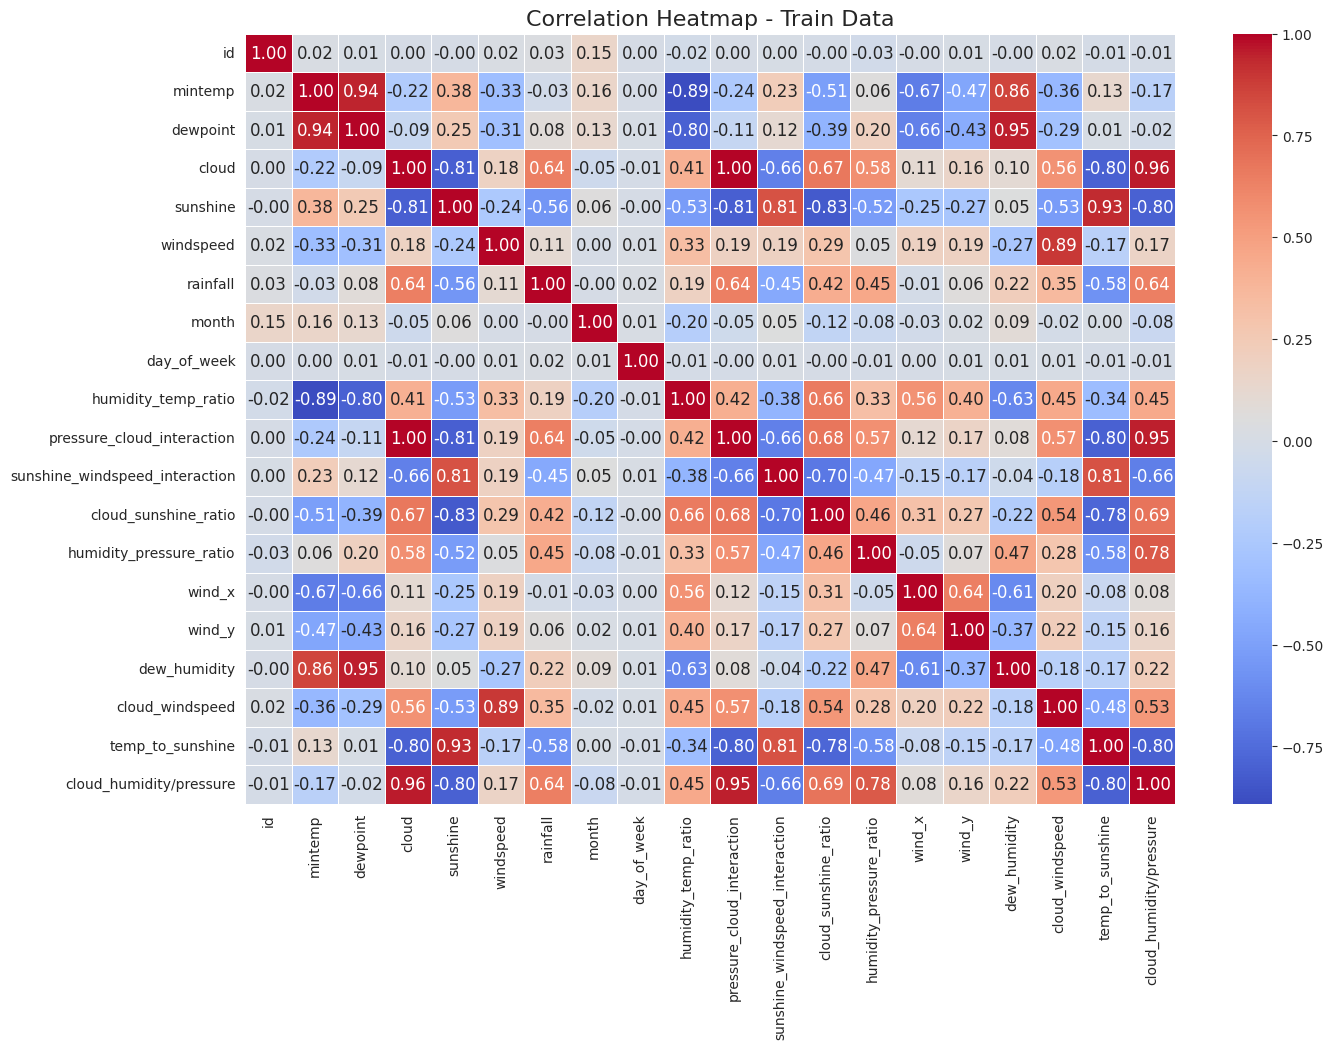

In [ ]:
corr_plot_heatmap(train_data.select_dtypes(exclude='object'), title='Train Data')

In [ ]:
def drop_unnecessary_features(df):
    """
    Drops redundant and weakly correlated features based on correlation analysis.
    """
    # Features to drop due to high correlation (≥ |0.9| with another feature)
    highly_correlated_features = ["mintemp", "cloud", "dew_humidity", "humidity_pressure_ratio"]

    # Features to drop due to weak correlation (≤ |0.05| with 'rainfall') - Optional
    weakly_correlated_features = ["day_of_week", "month"]

    # Combine all features to drop
    features_to_drop = highly_correlated_features + weakly_correlated_features

    # Drop the selected features
    df = df.drop(columns=features_to_drop, errors="ignore")

    return df

# Apply to train and test datasets
train_data = drop_unnecessary_features(train_data)
test_data = drop_unnecessary_features(test_data)

# Print remaining columns
print("Remaining Features:", train_data.columns.tolist())

Remaining Features: ['id', 'dewpoint', 'sunshine', 'windspeed', 'rainfall', 'humidity_temp_ratio', 'pressure_cloud_interaction', 'sunshine_windspeed_interaction', 'cloud_sunshine_ratio', 'wind_x', 'wind_y', 'cloud_windspeed', 'temp_to_sunshine', 'cloud_humidity/pressure']


In [ ]:
train_data.columns

Index(['id', 'dewpoint', 'sunshine', 'windspeed', 'rainfall',
       'humidity_temp_ratio', 'pressure_cloud_interaction',
       'sunshine_windspeed_interaction', 'cloud_sunshine_ratio', 'wind_x',
       'wind_y', 'cloud_windspeed', 'temp_to_sunshine',
       'cloud_humidity/pressure'],
      dtype='object')

## **Feature Target Split**

In [ ]:
# Select features and target variable
X_train = train_data.drop(columns=['rainfall', 'id'], axis = 1)
y_train = train_data[target_feature]
X_test = test_data.drop(columns=['id'], axis = 1)


# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

## **Models Bulding**

In [ ]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}


In [ ]:
# Define parameter grids for tuning
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    'Decision Tree': {
        'classifier__max_depth': [3, 5, 10, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, 10, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 10]
    },
    'Support Vector Machine': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    },
    'K-Nearest Neighbors': {
        'classifier__n_neighbors': [3, 5, 10],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    'Naive Bayes': {},  # No hyperparameters for GaussianNB
    'XGBoost': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 10]
    },
    'LightGBM': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 10]
    },
    'CatBoost': {
        'classifier__iterations': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__depth': [3, 5, 10]
    }
}

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

# Data (Assumes X_train, y_train are already defined)
best_models = {}

# Perform hyperparameter tuning for each model
for name, model in models.items():
    print(f"Tuning {name}...")

    # Create pipeline with scaling (if needed)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize features
        ('classifier', model)  # Add model
    ])

    # Check if model has a parameter grid
    if param_grids[name]:
        search = RandomizedSearchCV(
            pipeline, param_grids[name], n_iter=10, scoring='accuracy',
            cv=5, verbose=1, random_state=42, n_jobs=-1
        )
        search.fit(X_train, y_train)
        best_models[name] = search.best_estimator_
        print(f"Best params for {name}: {search.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_models[name] = model
        print(f"Default model used for {name} (no hyperparameters).")

# Print tuned models
print("Tuned Models:", best_models)


Tuning Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params for Logistic Regression: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__C': 0.01}
Tuning Decision Tree...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for Decision Tree: {'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 5}
Tuning Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for Random Forest: {'classifier__n_estimators': 50, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 5}
Tuning Gradient Boosting...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for Gradient Boosting: {'classifier__n_estimators': 50, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}
Tuning Support Vector Machine...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best pa

In [ ]:
# Final models with best parameters
fixed_models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=0.01, solver='liblinear', penalty='l2'))
    ]),

    'Decision Tree': DecisionTreeClassifier(
        max_depth=5, min_samples_split=10, min_samples_leaf=4
    ),

    'Random Forest': RandomForestClassifier(
        n_estimators=50, max_depth=5, min_samples_split=2, min_samples_leaf=4
    ),

    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=50, max_depth=3, learning_rate=0.1
    ),

    'Support Vector Machine': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(C=1, kernel='rbf', gamma='scale'))
    ]),

    'K-Nearest Neighbors': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier(n_neighbors=10, weights='uniform', metric='euclidean'))
    ]),

    'Naive Bayes': GaussianNB(),  # No hyperparameters needed

    'XGBoost': XGBClassifier(
        n_estimators=50, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss'
    ),

    'LightGBM': LGBMClassifier(
        n_estimators=50, max_depth=3, learning_rate=0.1
    ),

    'CatBoost': CatBoostClassifier(
        iterations=50, learning_rate=0.2, depth=5, verbose=0
    )
}

# Train all models
for name, model in fixed_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training Support Vector Machine...
Training K-Nearest Neighbors...
Training Naive Bayes...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Number of positive: 1650, number of negative: 540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2339
[LightGBM] [Info] Number of data points in the train set: 2190, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.753425 -> initscore=1.116961
[LightGBM] [Info] Start training from score 1.116961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Evaluating Logistic Regression...
Logistic Regression AUC Score: 0.8946
Evaluating Decision Tree...
Decision Tree AUC Score: 0.9145
Evaluating Random Forest...
Random Forest AUC Score: 0.9255
Evaluating Gradient Boosting...
Gradient Boosting AUC Score: 0.9323
Evaluating Support Vector Machine...
Support Vector Machine AUC Score: 0.8701
Evaluating K-Nearest Neighbors...
K-Nearest Neighbors AUC Score: 0.9248
Evaluating Naive Bayes...
Naive Bayes AUC Score: 0.8739
Evaluating XGBoost...
XGBoost AUC Score: 0.9266
Evaluating LightGBM...
LightGBM AUC Score: 0.9278
Evaluating CatBoost...
CatBoost AUC Score: 0.9276


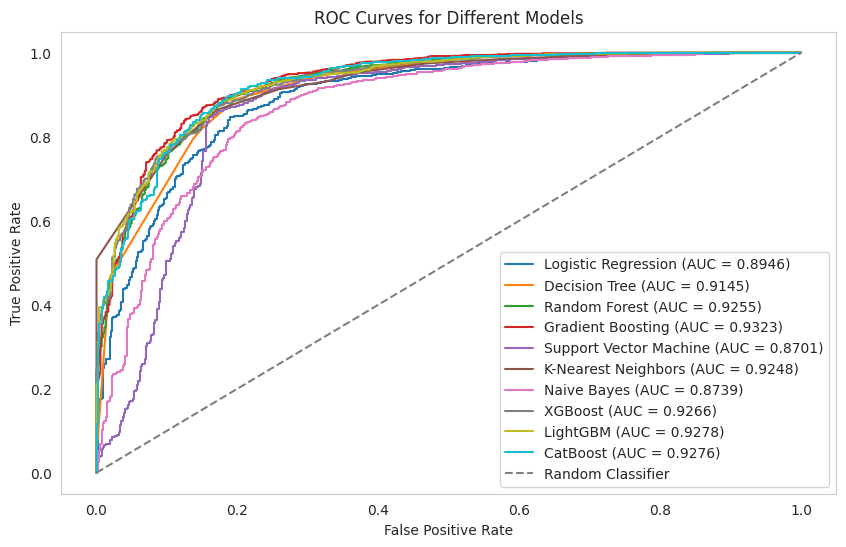

In [ ]:
# Dictionary to store AUC scores and ROC curves
auc_scores = {}
roc_curves = {}

# Train and evaluate models
for name, model in fixed_models.items():
    print(f"Evaluating {name}...")

    # Predict probabilities for ROC AUC calculation
    if hasattr(model, "predict_proba"):  # Check if model supports probability prediction
        y_prob = model.predict_proba(X_train)[:, 1]  # Take probability of class 1
    else:
        y_prob = model.decision_function(X_train)  # For SVM models without predict_proba

    # Compute AUC score
    auc_score = roc_auc_score(y_train, y_prob)
    auc_scores[name] = auc_score

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_train, y_prob)
    roc_curves[name] = (fpr, tpr)

    print(f"{name} AUC Score: {auc_score:.4f}")

# Plot ROC Curves
plt.figure(figsize=(10, 6))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_scores[name]:.4f})")

# Plot random classifier line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")

# Formatting the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Models")
plt.legend()
plt.grid()
plt.show()

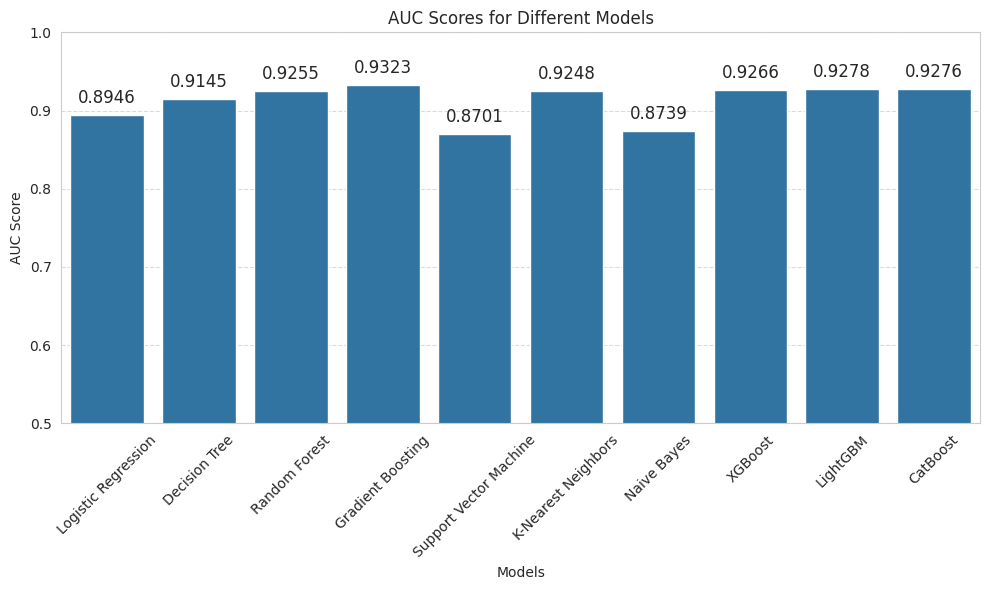

In [ ]:
# Plot AUC scores
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(auc_scores.keys()), y=list(auc_scores.values()))

# annotate the bars with AUC scores
for i, v in enumerate(auc_scores.values()):
    ax.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize = 12)

# Formatting the plot
plt.xticks(rotation=45)
plt.xlabel("Models")
plt.ylabel("AUC Score")
plt.title("AUC Scores for Different Models")
plt.ylim(0.5, 1)
plt.grid(axis = 'y', linestyle ='--', alpha = 0.7)
plt.tight_layout()
plt.show()

### **Define the Best Model**

In [ ]:
# Find the ebst model
best_model_name = max(auc_scores, key=auc_scores.get)
best_model = fixed_models[best_model_name]
print(f"The best model is {best_model_name} with AUC score {auc_scores[best_model_name]:.4f}.")

The best model is Gradient Boosting with AUC score 0.9323.


### **Visualize Feature Importance in the Best Model**

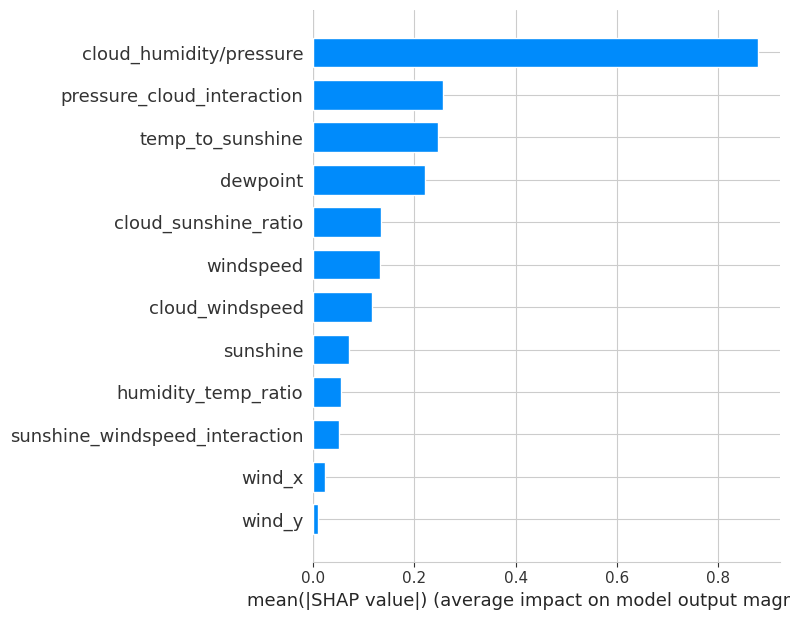

In [ ]:
# Using Explainer for shap values
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train)

# Visualize the first prediction's explanation
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
X_train.columns

Index(['dewpoint', 'sunshine', 'windspeed', 'humidity_temp_ratio',
       'pressure_cloud_interaction', 'sunshine_windspeed_interaction',
       'cloud_sunshine_ratio', 'wind_x', 'wind_y', 'cloud_windspeed',
       'temp_to_sunshine', 'cloud_humidity/pressure'],
      dtype='object')

## **Evaluating with Test data**

In [ ]:
from operator import sub
test_preds = best_model.predict_proba(X_test)[:, 1]

# submission
submission = pd.DataFrame({'id': test_data['id'], 'rainfall': test_preds})
submission.to_csv('submission.csv', index=False)
print("\nSubmission file as 'submission.csv")


Submission file as 'submission.csv


In [ ]:
submission

id  rainfall
0    2190  0.967255
1    2191  0.967255
2    2192  0.937150
3    2193  0.263242
4    2194  0.096629
..    ...       ...
725  2915  0.967255
726  2916  0.847759
727  2917  0.968153
728  2918  0.968153
729  2919  0.926296

[730 rows x 2 columns]